# Face Recognition

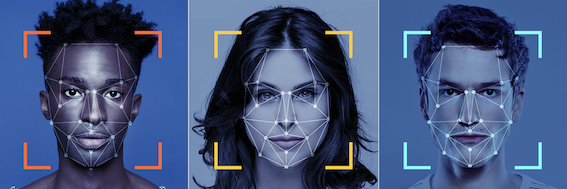

In this project we'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

As you see on the site, images of celebA dataset look like this:


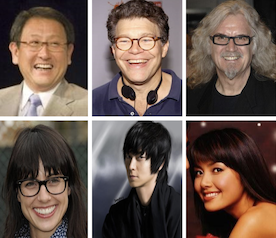

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face recognition model training and inference setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like. If you are familiar with this, you can skip this section.

### Model training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

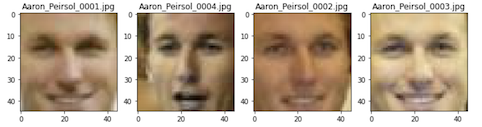

You see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model doesn't need to "search" for the face and eyes positions on the image before performing a recognition.

If you are interested, you can also train a model on non-aligned images, but you'll see that it would perform badly. It is possible though to train a model for face recognition without pre-alignment of all the faces, but this would require a huge amount of data — more that almost any company has. The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

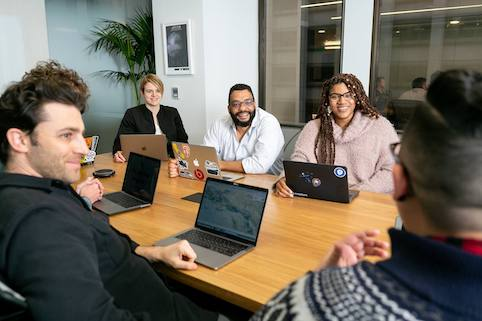

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

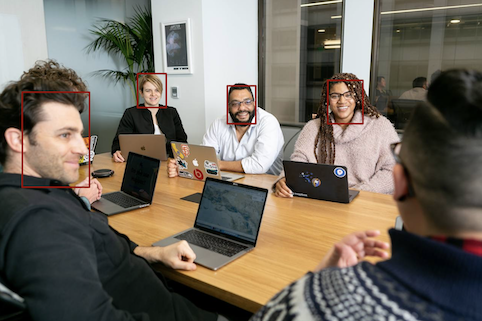

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

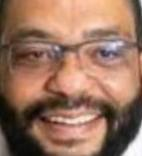

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural network model architecture 

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is. 

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people. 

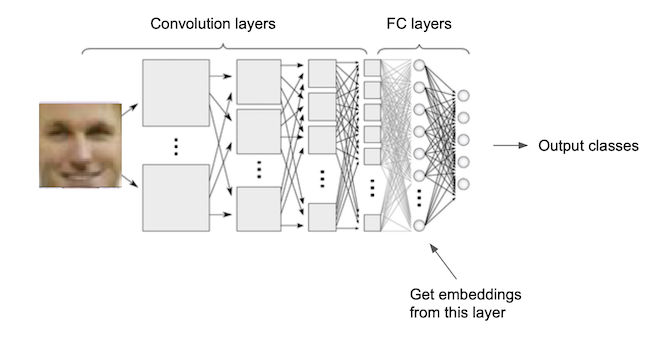

## Step 1 Let's build a neural network for faces classification as discribed above.

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw

In [1]:
!gdown https://drive.google.com/file/d/1RGbxTMHOvu5HonswD7Yl2c5r-Xk5XNAt/view?usp=sharing

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1RGbxTMHOvu5HonswD7Yl2c5r-Xk5XNAt
  url="https://drive.google.com/uc?id={}".format(file_id)
Downloading...
From: https://drive.google.com/file/d/1RGbxTMHOvu5HonswD7Yl2c5r-Xk5XNAt/view?usp=sharing
To: /content/view?usp=sharing
67.4kB [00:00, 567kB/s]


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!unzip -q /content/gdrive/MyDrive/Celeba/celebA.zip -d celebA_train_500

Let's look at the data first:

In [4]:
! ls celebA_train_500/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [5]:
import os
import cv2
import copy
import numpy as np
from PIL import Image
from skimage import io, transform


import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

from torch.optim import lr_scheduler
import torch.nn as nn
from tqdm import tqdm, tqdm_notebook, trange
from time import time
from torch import optim
from IPython.display import clear_output
import pandas as pd
import time
import random
import torch.nn.functional as F

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


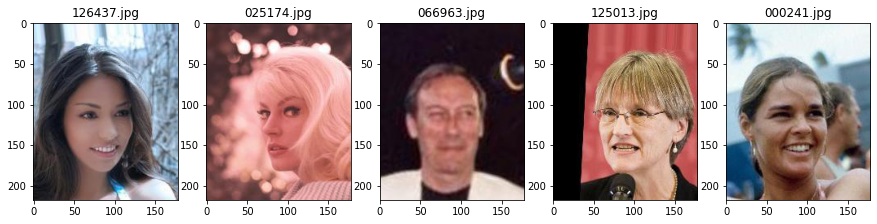

In [6]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_500/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names)


### Train Neural Network

Let's build a Datasets and network using this images:

In [6]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]

        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 
        
        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }
        
        sample['image'] = self.transform(sample['image'])

        # return sample
        return sample['image'], int(sample['label'])

    def get_imgs(self, person_number):
        photos = []
        for i, j in enumerate(self.labels):
            if j == person_number:
                photos.append(self.images[i])
        if len(photos) != 0:
            photos = torch.stack([self.transform(Image.open(x)) for x in photos])
        else:
            photos = torch.Tensor()
        return photos

### Let's look at data. How many photos does each person have?

In [9]:
import pandas as pd

f = open('celebA_train_500/celebA_anno.txt', 'r')
lines = f.readlines()
person = [x.strip().split() for x in lines]
person_images = dict()
for i in person:
  if i[1] not in person_images:
    person_images[i[1]] = []
  person_images[i[1]].append(i[0])

df = pd.DataFrame(data=person_images.items(), columns=['person', 'images'])
df['img_amount'] = df['images'].str.len()
df = df.drop('person', axis=1)
df

,images,img_amount
0,"[000001.jpg, 000404.jpg, 003415.jpg, 004390.jp...",30
1,"[000002.jpg, 011437.jpg, 016335.jpg, 017121.jp...",30
2,"[000003.jpg, 015648.jpg, 033840.jpg, 038887.jp...",30
3,"[000004.jpg, 001778.jpg, 010191.jpg, 013676.jp...",30
4,"[000005.jpg, 008431.jpg, 014427.jpg, 016680.jp...",25
...,...,...
995,"[001088.jpg, 001499.jpg, 005623.jpg, 013837.jp...",28
996,"[001089.jpg, 007850.jpg, 017894.jpg, 019663.jp...",15
997,"[001090.jpg, 008073.jpg, 011233.jpg, 038357.jp...",21
998,"[001091.jpg, 002533.jpg, 014773.jpg, 015681.jp...",22


### Let's create a histogram to look at the ratio of the data

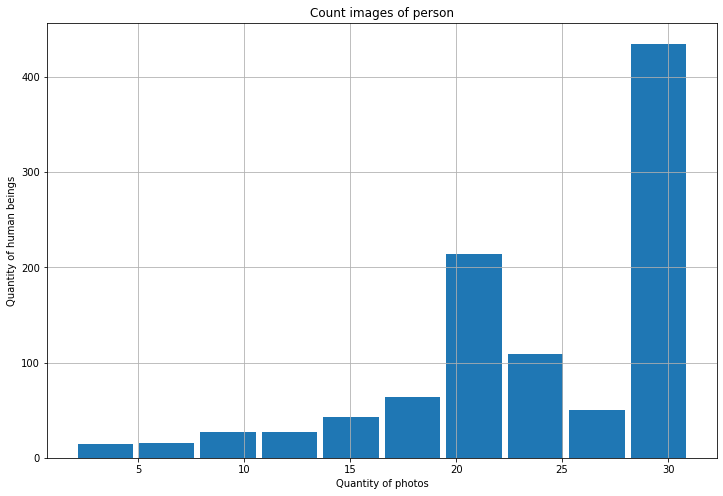

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(df['img_amount'], histtype='bar', rwidth=0.9)
plt.title('Count images of person')
plt.xlabel('Quantity of photos')
plt.ylabel('Quantity of human beings')
plt.grid()
plt.show()

### We could see some disbalance of data. More than 200 people have 30 photos. But 100 people more have only 20 photos, Furthermore there are some people who has less than 20 photos. We could understand that we have to apply augmentation. 

### Let's see if I'm right? Look at output data from 1 random person.

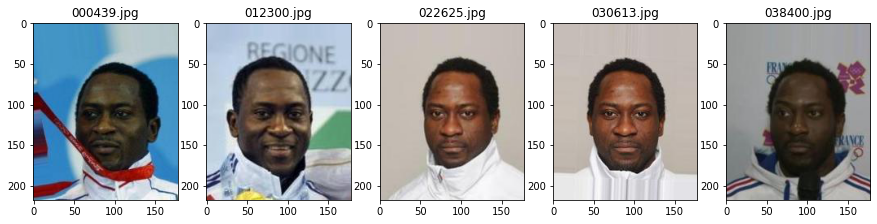

In [ ]:
import random 

images_repeats = df.iloc[random.randint(0, len(df))]['images'][:5]
show_imgs(images_repeats)

### I decided to use augmentation: ColorJitter and RandomHorizontalFlip. I thought to use ImbalancedDatasetSampler but I'm not sure that it was good idea to use all of it. Later probably I will try SMOTE.


In [7]:
transform = transforms.Compose([
      # you may add anything, e.g. augmentation
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_transform = transforms.Compose([
      transforms.Resize(160),
      transforms.ToTensor(),
      transforms.ColorJitter(),
      transforms.RandomHorizontalFlip(),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

train_data = celebADataset('train', train_transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

# choose your own batch_size
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

We'll use pretrained on VGGFace2 network InceptionResnetV1 from here: https://github.com/timesler/facenet-pytorch/tree/master/models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [8]:
! git clone https://github.com/timesler/facenet-pytorch.git
! mv facenet-pytorch/models ./

Cloning into 'facenet-pytorch'...
remote: Enumerating objects: 1267, done.
remote: Total 1267 (delta 0), reused 0 (delta 0), pack-reused 1267
Receiving objects: 100% (1267/1267), 22.88 MiB | 13.29 MiB/s, done.
Resolving deltas: 100% (619/619), done.


In [9]:
! ls models

inception_resnet_v1.py	mtcnn.py  utils


In [10]:
from models import inception_resnet_v1
model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=True, num_classes = 1000)

  0%|          | 0.00/107M [00:00<?, ?B/s]

**Workflow**: fine-tune a model on train_data using val_data for validation.Use standard CE loss.  Calculate the loss and accuracy on test set after training. 

You may use any optimizer you want and any learning rate. It is also beneficial to freeze starting layers to boost training speed and avoid overfitting. 

**To get the whole mark for this section you need to achieve 80% accuracy on test set**.

In [ ]:
# YOUR CODE HERE: fine-tune your model on train set and evaluate it on test set
# Function for freezing layers.
def freeze_layers(module):
    for param in module.parameters():
        param.requires_grad = False

In [ ]:
import time
def train(model, num_epochs, criterion, optimizer, train_loader, val_loader):

    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        """ Training Phase """
        model.train()

        running_loss = 0.
        running_corrects = 0

        # load a batch data of images
        for inputs, labels in train_loader:
            # inputs = item['image'].to(DEVICE)
            # labels = item['label'].to(DEVICE)
            inputs = torch.from_numpy(np.asarray(inputs)).to(DEVICE)
            labels = torch.from_numpy(np.asarray(labels)).to(DEVICE)

            # forward inputs and get output
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # get loss value and update the network weights
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_data)
        epoch_acc = running_corrects.double() / len(train_data) * 100.
        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

        """ Test Phase """
        model.eval()

        with torch.no_grad():
            running_loss = 0.
            running_corrects = 0

            for inputs, labels in val_loader:
                inputs = torch.from_numpy(np.asarray(inputs)).to(DEVICE)
                labels = torch.from_numpy(np.asarray(labels)).to(DEVICE)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(val_data)
            epoch_acc = running_corrects.double() / len(val_data) * 100.
            print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    model.load_state_dict(best_model_wts)

    return running_loss, running_corrects, model

### Trying to freeze a few first layers

In [ ]:
freeze_layers(model.conv2d_1a)
freeze_layers(model.conv2d_2a)
freeze_layers(model.conv2d_2b)
freeze_layers(model.maxpool_3a)
freeze_layers(model.conv2d_3b)
freeze_layers(model.conv2d_4a)
freeze_layers(model.conv2d_4b)

In [ ]:
DEVICE = torch.device("cuda")

model.to(DEVICE)

# cost function
criterion = nn.CrossEntropyLoss()

# AdamW as opitmizer
optimizer = optim.AdamW(model.parameters(), lr = 3e-4)

max_epochs = 10

In [ ]:
%%time 
running_loss, running_corrects, model = train(model, max_epochs, criterion, optimizer, train_loader, val_loader)

[Train #0] Loss: 4.9656 Acc: 23.2891% Time: 87.8230s
[Test #0] Loss: 3.5281 Acc: 53.0782% Time: 99.2140s

[Train #1] Loss: 2.1285 Acc: 73.1013% Time: 186.5685s
[Test #1] Loss: 1.5459 Acc: 81.0493% Time: 197.9508s

[Train #2] Loss: 0.8753 Acc: 90.6034% Time: 285.3814s
[Test #2] Loss: 1.3546 Acc: 78.6938% Time: 296.7805s

[Train #3] Loss: 0.3943 Acc: 96.1380% Time: 384.0589s
[Test #3] Loss: 0.6971 Acc: 88.7313% Time: 395.4347s

[Train #4] Loss: 0.2008 Acc: 98.0808% Time: 482.8887s
[Test #4] Loss: 0.6561 Acc: 88.1156% Time: 494.2812s

[Train #5] Loss: 0.1064 Acc: 99.2311% Time: 581.6259s
[Test #5] Loss: 0.7814 Acc: 84.3951% Time: 593.0004s

[Train #6] Loss: 0.0800 Acc: 99.4835% Time: 680.3622s
[Test #6] Loss: 0.5450 Acc: 89.4540% Time: 691.7551s

[Train #7] Loss: 0.0465 Acc: 99.7476% Time: 779.2230s
[Test #7] Loss: 0.4413 Acc: 91.4882% Time: 790.6415s

[Train #8] Loss: 0.0251 Acc: 99.8533% Time: 878.2517s
[Test #8] Loss: 0.4522 Acc: 91.1670% Time: 889.7283s

[Train #9] Loss: 0.0209 Acc: 9

Validation accuracy is 0.92. The best was 0.92 on the 10th epoch.



In [ ]:
torch.save(model.state_dict(), 'model.pth')


In [ ]:
def calc_accuracy(model):
    model.eval()  # testing mode
    with torch.no_grad():
        correct = 0
        for inputs, labels in test_loader:
            inputs = torch.from_numpy(np.asarray(inputs)).to(DEVICE)
            logits = model(inputs)
            classes = np.argmax(logits.cpu().numpy(), axis=1)
            correct += (labels.numpy() == classes).sum()
    return correct / len(test_data)

In [53]:
model1 = model
model1.load_state_dict(torch.load('model.pth'))
model1.eval()
model1.to(DEVICE)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [ ]:
calc_accuracy(model1)

0.9120982986767486

## Accuracy on the test set is **0.912** which is more than 80%. Task was succesfully completed then.






**Cosine similarity calculation**: drop a last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [54]:
model1.classify=False

In [ ]:
model1.eval()
with torch.no_grad():
    x1 = model1(train_data.get_imgs(12).to(DEVICE))
    x2 = model1(test_data.get_imgs(12).to(DEVICE))
    x3 = model1(test_data.get_imgs(13).to(DEVICE))


In [ ]:
print(cosine_similarity(x1.cpu(), x2.cpu()).mean())
print(cosine_similarity(x1.cpu(), x3.cpu()).mean())

0.7252612
-0.04224905


As we could see cousine similarity is working. Photos of the same person from train and test data set show us 0.72 CS. But photos of the different persons shows us -0.04. So it's working well.

**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset. 

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between up to 5k, as an example.

In [ ]:
from IPython.display import clear_output
import pandas as pd

number_of_people = 10
main_result = []
model1.eval()
with torch.no_grad():
    for i in range(number_of_people):
        print(f'{i+1}/{number_of_people} human beings analysis...')
        results = []
        x1 = model1(train_data.get_imgs(i).to(DEVICE))
        for j in range(number_of_people):
            if (len((test_data.get_imgs(j)) != 0)) and (len(train_data.get_imgs(i)) != 0):
                x2 = model1(test_data.get_imgs(j).to(DEVICE))
                results.append(cosine_similarity(x1.cpu(), x2.cpu()).mean())
            else:
                results.append(0.0)
        main_result.append(results)
        clear_output(wait=True)
result_df = pd.DataFrame(np.array(main_result))
print(f"The analysis gave you {number_of_people**2} person's mean of cosine similarity") 

The analysis gave you 100 person's mean of cosine similarity


In [ ]:
result_df.iloc[:5, :5]

,0,1,2,3,4
0,0.747781,-0.058430,-0.186750,0.147489,0.025065
1,-0.008061,0.697476,-0.095574,-0.064478,0.031769
2,-0.150178,0.055891,0.687469,-0.028710,-0.370135
3,0.207592,-0.090285,-0.151078,0.654183,0.056667
4,-0.003788,-0.010428,-0.262330,-0.007232,0.516150


Let's see our results on the heatmap:

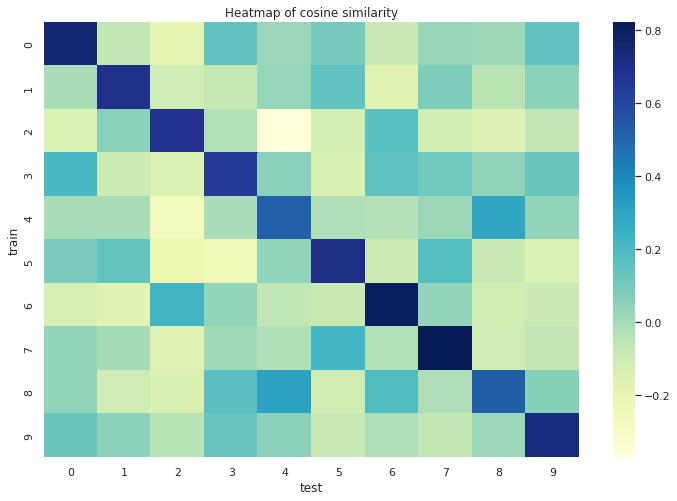

In [ ]:
sns.set(rc={'figure.figsize':(12, 8)})
fig = sns.heatmap(np.array(main_result), cmap="YlGnBu")
plt.title('Heatmap of cosine similarity')
plt.xlabel('test')
plt.ylabel('train')
plt.show()

So as we could see we have pretty good cosine similarity for the same person from the test and train set. But if we compare differrent persons photos we are getting low score of cosine similarity which is good.

## Step 2 Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how good a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos. 
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary. 

Datasets (query photos, query labels & distructors photos) you can download from here: https://disk.yandex.ru/d/C54mClLmQkag6Q

**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.

In [44]:
!gdown https://drive.google.com/file/d/1VYtPbyuqqa2YC1P7ugWgGQZ2dXSKyJE2/view?usp=sharing -O celebA_ir.zip

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1VYtPbyuqqa2YC1P7ugWgGQZ2dXSKyJE2
  url="https://drive.google.com/uc?id={}".format(file_id)
Downloading...
From: https://drive.google.com/file/d/1VYtPbyuqqa2YC1P7ugWgGQZ2dXSKyJE2/view?usp=sharing
To: /content/celebA_ir.zip
67.5kB [00:00, 577kB/s]


In [45]:
!unzip -q /content/gdrive/MyDrive/Celeba/celebA_ir.zip -d celebA_ir

In [46]:
!ls celebA_ir/

celebA_anno_query.txt  celebA_distractors  celebA_query


In [47]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format: 
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./celebA_ir/celebA_anno_query.txt', 'r')
query_lines = f.readlines()
f.close()
query_lines = [x.strip().split() for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = ['./celebA_ir/celebA_query/{}'.format(x[0]) for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = ['./celebA_ir/celebA_distractors/{}'.format(x) for x in os.listdir('./celebA_ir/celebA_distractors')]

Let's see the len of ours data

In [48]:
print(len(distractors_img_names))
print(len(query_img_names))
print(len(query_dict))

23397
7198
300


Creating new Dataset with transform in it:

In [49]:
class celebANewDataset(Dataset):
    def __init__(self, images_list):
        self.images = images_list
        self.transform = transforms.Compose([
                                  transforms.Resize(160),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
    
    def __len__(self):
        return len(self.images)
    
    def get_tensors(self):
        images = torch.stack([self.transform(Image.open(img_name)) for img_name in self.images])
        return images

In [50]:
def compute_embeddings(model, images_list):
  '''
  compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images 
          names from images_list
  '''
  data = celebANewDataset(images_list)

  model.to(DEVICE)
  batch_size = 64
  loader = torch.utils.data.DataLoader(data.get_tensors(), batch_size=batch_size, shuffle=False)

  if len(images_list) != 0:
      model.eval()
      embeddings = []
      with torch.no_grad():
          for x in loader:
              outputs = model(x.to(DEVICE))
              embeddings.append(outputs.cpu())
      return torch.cat(embeddings)
  else:
      raise NotImplementedError

In [55]:
query_embeddings = compute_embeddings(model1, query_img_names)

In [56]:
distractors_embeddings = compute_embeddings(model1, distractors_img_names)

In [57]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

I'll use here np.trill which helps me to delete values of the same images. It returns a copy of an array with elements above the k-th diagonal zeroed. And after that we will replace zeros to nan and after we'll delete nans.

In [58]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to the same people from query list
  '''
  for person_class in query_dict:
      if query_dict[person_class][0] not in query_img_names:
          PATH = './celebA_ir/celebA_query/{}'
      else:
          PATH = '{}'
      break

  full_embeddings = torch.Tensor()

  for person_class in query_dict:
      images = [PATH.format(x) for x in query_dict[person_class]]
      person_embeddings = []
      for image_path in images:
          person_embeddings.append(
              torch.Tensor(query_embeddings[query_img_names.index(image_path)])
          )
      if len(person_embeddings) == 0:
          person_embeddings = torch.Tensor
          result = 0.0
      else:
          person_embeddings = torch.stack(person_embeddings)
          result = cosine_similarity(np.array(person_embeddings), np.array(person_embeddings))
          df = pd.DataFrame(result)

          df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_))).values.reshape(-1) # remove unnecessary values and replaced it with nan
          # print(df)
          useful_result = df[~np.isnan(df)] # drop nan
          # print(useful_result)

          useful_result = torch.Tensor(useful_result).view(-1)
          full_embeddings = torch.cat((full_embeddings, useful_result))

  results = [i.item() for i in full_embeddings]
  plt.hist(results)
  plt.show()
  # print(f'Embeddings = {results}')
  print(f'Count embeddings = {len(results)}')
  return results

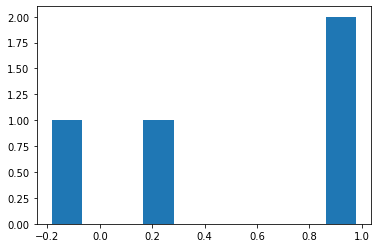

Count embeddings = 4


In [59]:
test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)

In [60]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), "A mistake in compute_cosine_query_pos function"

In [61]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similaries between negative pairs from query (stage 2)
    params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
    output:
        list of floats: similarities between embeddings corresponding
                        to different people from query list
    '''
    for person_class in query_dict:
        if query_dict[person_class][0] not in query_img_names:
            PATH = './celebA_ir/celebA_query/{}'
        else:
            PATH = '{}'
        break

    full_embeddings = torch.Tensor()
    class_counter = []

    k = 0
    for person_class in query_dict:
        k += 1
        print(f'Analyse {k} person of {len(query_dict)}...')
        images = [PATH.format(x) for x in query_dict[person_class]]
        class_counter.extend([person_class for i in range(len(images))])

        person_embeddings = []
        for image_path in images:
            person_embeddings.append(
                torch.Tensor(query_embeddings[query_img_names.index(image_path)])
            )
        if len(person_embeddings) == 0:
            person_embeddings = torch.Tensor
            result = 0.0
        else:
            person_embeddings = torch.stack(person_embeddings)
            # person_embeddings = torch.Tensor(person_embeddings).view(-1)
            full_embeddings = torch.cat((full_embeddings, person_embeddings))
        clear_output(wait=True)
    all_data = pd.DataFrame(data={'class': class_counter, 'embeddings': list(full_embeddings)})
    results = cosine_similarity(full_embeddings, full_embeddings)                                                                                                                                                   
    results = pd.DataFrame(data=results, index=class_counter, columns=class_counter)

    k = 0
    for i in results:
        k += 1
        print(f'Analyse {k} row of {len(results)}...')
        results.loc[i, i] = np.nan
        clear_output(wait=True)
    
    df = results.mask(np.tril(np.ones(results.shape, dtype=np.bool_))).values.reshape(-1) # remove unnecessary values and replaced it with nan
    useful_result = df[~np.isnan(df)] # drop nan
    plt.hist(useful_result)
    plt.show()
    print('Cosine similarities =', useful_result)
    print('Count of cosine similarities =', len(useful_result))
    return useful_result

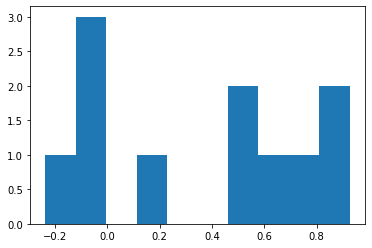

Cosine similarities = [ 0.15963231  0.85079974  0.92727613 -0.06439941  0.54126614  0.7013071
 -0.23725756  0.69410324  0.5494254  -0.01198273 -0.04666791]
Count of cosine similarities = 11


In [62]:
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
                                                 test_query_embeddings)

In [63]:
true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), "A mistake in compute_cosine_query_neg function"

In [64]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
        query_embeddings: list of embeddings corresponding to query_img_names
        distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
        list of floats: similarities between pairs of people(q, d) where q is
                        embedding corresponding to photo from query, d -
                        embedding corresponding to photo from distractors
    '''
    results = cosine_similarity(query_embeddings, distractors_embeddings)
    results = results.reshape(-1)
    plt.hist(results)
    plt.show()
    print('Count of cosine similarities =', len(results))
    return results
    

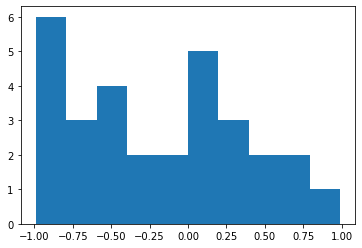

Count of cosine similarities = 30


In [65]:
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, 
                                                            test_distractors_embeddings)

In [66]:
true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), "A mistake in compute_cosine_query_distractors function"

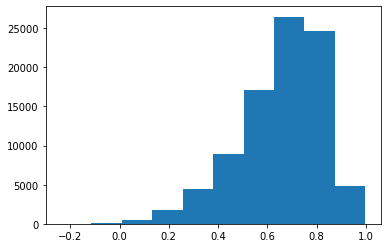

Count embeddings = 88952


In [67]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
                                            query_embeddings)

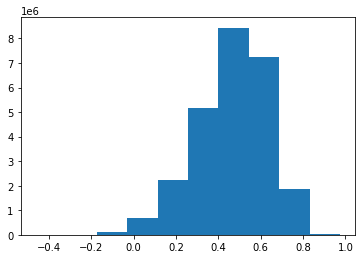

Cosine similarities = [0.2713439  0.2342695  0.615462   ... 0.76711524 0.6526098  0.64576477]
Count of cosine similarities = 25813051


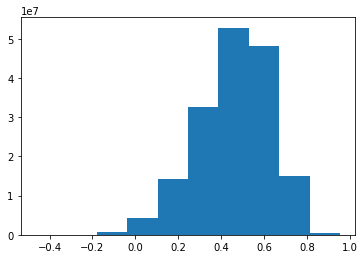

Count of cosine similarities = 168411606


In [68]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)


Check you code of functions which compute similarities:

Implement the final function: identification rate calculation

In [69]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
      cosine_query_pos: cosine similarities between positive pairs from query
      cosine_query_neg: cosine similarities between negative pairs from query
      cosine_query_distractors: cosine similarities between negative pairs 
                                from query and distractors
      fpr: false positive rate at which to compute TPR
    output: 
      float: threshold for given fpr 
      float: TPR at given FPR
    '''
    cosine_query_pos = torch.Tensor(cosine_query_pos)
    cosine_query_neg = torch.Tensor(cosine_query_neg)
    cosine_query_distractors = torch.Tensor(cosine_query_distractors)

    false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
    N = round(fpr * len(false_pairs))
    false_pairs = torch.sort(false_pairs, descending = True)[0]
    threshold = false_pairs[N]
    TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
    return threshold.item(), TPR

In [70]:
compute_ir(test_cosine_query_pos, test_cosine_query_neg, test_cosine_query_distractors, fpr=0.1)

(0.7013071179389954, 0.5)

Check yourself:

In [71]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  print(f'Analyse by fpr = {fpr}')
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)
  clear_output(wait=True)

print(test_thr)
print(test_tpr)

[-0.01198272779583931, 0.3371426463127136, 0.7013071179389954]
[0.75, 0.5, 0.5]


In [72]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [73]:
all_test_thr = []
all_test_tpr = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
    print(f'Analyse by fpr = {fpr}')
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                      test_cosine_query_distractors, fpr=fpr)
    all_test_thr.append(x)
    all_test_tpr.append(y)
    clear_output(wait=True)

print(all_test_thr)
print(all_test_tpr)

[-0.01198272779583931, 0.541266143321991, 0.7013071179389954, 0.8507997393608093]
[0.75, 0.5, 0.5, 0.5]


## Step 3 Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other. 

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo. 

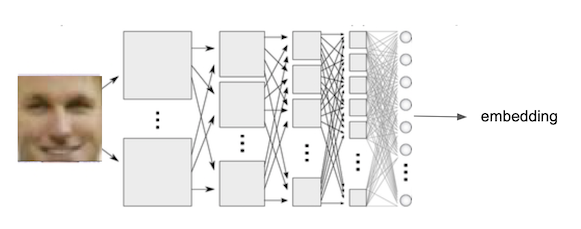

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$  is embedding of a photo (output of a model)
- $p$  is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$  is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$  is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$ 
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results.

Which loss among which you have tried is the best?

**To get the full mark for this task you need to train a model using  TripletLoss correctly at least for one value of margin and achieve >=75% acc on test set.** 
As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embedding v from val and test sets calculate cosine similarities between v and mean embeddings from train set. (the more "right" way, but requires code writing)

You can use any of those two variants.

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

In [13]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)

In [24]:
class TripletLoss(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)
        self.dataset_type = dataset_type

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]
        self.transform = transform

        self.df = pd.DataFrame(data={'original': self.images, 'label': self.labels})

        triplet_df = pd.DataFrame(columns=['label', 'positive', 'negative'])
        for label in trange(1000):
            negatives = list(self.df[self.df.label != label].original.values)
            positives = list(self.df[self.df.label == label].original.values)
            triplet_df = triplet_df.append({'label': label, 'positives': positives, 'negatives': negatives}, ignore_index=True)
        self.triplet_df = triplet_df
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        anchor = self.images[idx]
        anchor_tensor = self.transform(Image.open(anchor))

        if self.dataset_type in ['train', 'val']:
            all_positives = self.triplet_df[self.triplet_df.label == label].positives.values[0]
            all_negatives = self.triplet_df[self.triplet_df.label == label].negatives.values[0]

            positive = random.choice(all_positives)
            negative = random.choice(all_negatives)

            positive_tensor = self.transform(Image.open(positive))
            negative_tensor = self.transform(Image.open(negative))

            return anchor_tensor, positive_tensor, negative_tensor, label
        else:
            return anchor_tensor, label


In [25]:
train_triplet = TripletLoss('train', train_transform)
val_triplet = TripletLoss('val', transform)
test_triplet = TripletLoss('test', transform)

100%|██████████| 1000/1000 [00:04<00:00, 201.05it/s]


In [26]:
batch_size = 64
train_triplet_loader = torch.utils.data.DataLoader(train_triplet, batch_size=batch_size, shuffle=True)
val_triplet_loader = torch.utils.data.DataLoader(val_triplet, batch_size=batch_size, shuffle=False)
test_triplet_loader = torch.utils.data.DataLoader(test_triplet, batch_size=batch_size, shuffle=False)

In [27]:
def train_triplet_loss(model, train_loader, val_loader, opt, epochs=10, MARGIN=1.0):
    train_losses, val_losses, val_full_acc = [], [], []
    best_acc = 0.0

    triplet_loss = nn.TripletMarginWithDistanceLoss(
        distance_function = lambda x, y: 1.0 - F.cosine_similarity(x,y),
        margin = MARGIN
    )

    best_tripletloss_weights = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        print('========= Epoch %d/%d =========' % (epoch+1, epochs))
        # train loop
        model.train()
        current_train_loss = 0

        for anchor, positive, negative, label in train_loader:
            #forward pass
            opt.zero_grad()

            anchor_emb = model(anchor.to(DEVICE))
            positive_emb = model(positive.to(DEVICE))
            negative_emb = model(negative.to(DEVICE))

            outp = triplet_loss(anchor_emb, positive_emb, negative_emb)

            #backward pass
            outp.backward()
            opt.step()

            current_train_loss += outp.item()

        train_loss = current_train_loss / len(train_loader)
        train_losses.append(train_loss)
        print(f'Train loss: {train_loss:.4f}')

        model.eval()
        with torch.no_grad():
            for label in trange(1000):
                positives = list(train_triplet.df[train_triplet.df.label == label].original.values)                                      
                label_tensors = torch.stack([train_triplet.transform(Image.open(i)) for i in positives])
                model = model.cpu()
                label_embedding = model(label_tensors).detach().numpy()
                label_mean_embedding = np.expand_dims(np.mean(label_embedding, 0), 0)
                if label == 0:
                    list_embeddings = label_mean_embedding
                    continue
                list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)
        model = model.to(DEVICE)

        #validation loop
        model.eval()

        current_val_loss = 0
        current_val_correct = 0

        with torch.no_grad():
            for anchor, positive, negative, label in val_loader:
                anchor_emb = model(anchor.to(DEVICE))
                positive_emb = model(positive.to(DEVICE))
                negative_emb = model(negative.to(DEVICE))

                outp = triplet_loss(anchor_emb, positive_emb, negative_emb)

                cos = cosine_similarity(anchor_emb.cpu(), list_embeddings)
                result = torch.argmax(torch.Tensor(cos), 1)
                current_val_loss += outp.item()
                current_val_correct += torch.sum(result == label).item()

        val_loss = current_val_loss / len(val_loader)
        val_acc = current_val_correct / len(val_triplet)
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)

        print(f'Val loss: {val_loss:.4f}')

        print(f'You guessed {current_val_correct} of {len(val_triplet)} labels')
        print(f'Val accuracy: {val_acc*100:.4f}%')

        if val_acc > best_acc:
            best_acc = val_acc
            best_tripletloss_weights = copy.deepcopy(model.state_dict())
            print('New model was saved!')

    return best_tripletloss_weights, train_losses, val_losses, val_full_acc

In [28]:
def get_list_embeddings(model):
    model.eval()
    with torch.no_grad():
        model = model.cpu()
        for label in trange(1000):
            positives = list(train_triplet.df[train_triplet.df.label == label].original.values)
            label_tensors = torch.stack([train_triplet.transform(Image.open(i)) for i in positives])
            label_embedding = model(label_tensors).detach().numpy()
            label_mean_embedding = np.expand_dims(np.mean(label_embedding, 0), 0)
            if label == 0:
                list_embeddings = label_mean_embedding
                continue
            list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)
    return list_embeddings

In [29]:
def testing_triplet(model, test_loader, list_embeddings):
    model.eval()
    with torch.no_grad():
        current_correct = 0
        for anchor, label in test_loader:
            anchor_emb = model(anchor.to(DEVICE)).cpu()
            cos = cosine_similarity(anchor_emb.detach().numpy(), list_embeddings)
            result = torch.argmax(torch.Tensor(cos), 1)
            current_correct += torch.sum(result == label).item()

    test_acc = current_correct / len(test_triplet)

    first_text = f'You guessed {current_correct} of {len(test_triplet)} labels'
    second_text = f'Test accuracy: { test_acc*100:.3f}%'
    return current_correct, test_acc 

We are looking for the best margin for our model. So model with the best result will be saved.

In [31]:
models_info = {}
EPOCHS = 2
for MARGIN in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    print(f'Test margin = {MARGIN}')

    #loading model
    TripletLoss_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)

    for param in TripletLoss_model.parameters():
        param.requires_grad = False

    TripletLoss_model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
    TripletLoss_model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

    TripletLoss_model.to(DEVICE)

    #training
    opt = optim.AdamW(filter(lambda p: p.requires_grad, TripletLoss_model.parameters()))
    best_tripletloss_weights, train_loss_TL, val_loss_TL, acc_TL = train_triplet_loss(TripletLoss_model, train_triplet_loader, val_triplet_loader, opt, epochs=EPOCHS, MARGIN=MARGIN)

    models_info[MARGIN] = [best_tripletloss_weights, train_loss_TL, val_loss_TL, acc_TL]

    #save model
    best_TL_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
    best_TL_model.load_state_dict(best_tripletloss_weights)

    #test model
    print('Start testing')
    list_embeddings = get_list_embeddings(best_TL_model.to(DEVICE))
    current_correct, test_acc = testing_triplet(best_TL_model.to(DEVICE), test_triplet_loader, list_embeddings)
    models_info[MARGIN].extend([current_correct, test_acc])
    print(f'Guessed {current_correct} of {len(test_triplet)} labels')
    print(f'Test accuracy: {test_acc*100:.3f}%')
    print()

Test margin = 0.5
========= Epoch 1/2 =========
Train loss: 0.0833


100%|██████████| 1000/1000 [12:06<00:00,  1.38it/s]


Val loss: 0.0356
You guessed 3221 of 3736 labels
Val accuracy: 86.2152%
New model was saved!
========= Epoch 2/2 =========
Train loss: 0.0661


100%|██████████| 1000/1000 [11:56<00:00,  1.40it/s]


Val loss: 0.0377
You guessed 3240 of 3736 labels
Val accuracy: 86.7238%
New model was saved!
Start testing


100%|██████████| 1000/1000 [11:54<00:00,  1.40it/s]


Guessed 2711 of 3174 labels
Test accuracy: 85.413%

Test margin = 0.6
========= Epoch 1/2 =========
Train loss: 0.1282


100%|██████████| 1000/1000 [11:57<00:00,  1.39it/s]


Val loss: 0.0606
You guessed 3139 of 3736 labels
Val accuracy: 84.0203%
New model was saved!
========= Epoch 2/2 =========
Train loss: 0.1042


100%|██████████| 1000/1000 [12:01<00:00,  1.39it/s]


Val loss: 0.0607
You guessed 3110 of 3736 labels
Val accuracy: 83.2441%
Start testing


100%|██████████| 1000/1000 [12:27<00:00,  1.34it/s]


Guessed 2657 of 3174 labels
Test accuracy: 83.711%

Test margin = 0.7
========= Epoch 1/2 =========
Train loss: 0.1836


100%|██████████| 1000/1000 [12:47<00:00,  1.30it/s]


Val loss: 0.1014
You guessed 3018 of 3736 labels
Val accuracy: 80.7816%
New model was saved!
========= Epoch 2/2 =========
Train loss: 0.1495


100%|██████████| 1000/1000 [12:04<00:00,  1.38it/s]


Val loss: 0.0970
You guessed 3010 of 3736 labels
Val accuracy: 80.5675%
Start testing


100%|██████████| 1000/1000 [12:04<00:00,  1.38it/s]


Guessed 2520 of 3174 labels
Test accuracy: 79.395%

Test margin = 0.8
========= Epoch 1/2 =========
Train loss: 0.2452


100%|██████████| 1000/1000 [11:53<00:00,  1.40it/s]


Val loss: 0.1446
You guessed 2910 of 3736 labels
Val accuracy: 77.8908%
New model was saved!
========= Epoch 2/2 =========
Train loss: 0.2098


100%|██████████| 1000/1000 [11:57<00:00,  1.39it/s]


Val loss: 0.1489
You guessed 2853 of 3736 labels
Val accuracy: 76.3651%
Start testing


100%|██████████| 1000/1000 [11:47<00:00,  1.41it/s]


Guessed 2419 of 3174 labels
Test accuracy: 76.213%

Test margin = 0.9
========= Epoch 1/2 =========
Train loss: 0.3174


100%|██████████| 1000/1000 [11:59<00:00,  1.39it/s]


Val loss: 0.1998
You guessed 2756 of 3736 labels
Val accuracy: 73.7687%
New model was saved!
========= Epoch 2/2 =========
Train loss: 0.2702


100%|██████████| 1000/1000 [11:59<00:00,  1.39it/s]


Val loss: 0.1839
You guessed 2697 of 3736 labels
Val accuracy: 72.1895%
Start testing


100%|██████████| 1000/1000 [11:48<00:00,  1.41it/s]


Guessed 2316 of 3174 labels
Test accuracy: 72.968%

Test margin = 1.0
========= Epoch 1/2 =========
Train loss: 0.3997


100%|██████████| 1000/1000 [12:35<00:00,  1.32it/s]


Val loss: 0.2625
You guessed 2584 of 3736 labels
Val accuracy: 69.1649%
New model was saved!
========= Epoch 2/2 =========
Train loss: 0.3420


100%|██████████| 1000/1000 [11:53<00:00,  1.40it/s]


Val loss: 0.2589
You guessed 2492 of 3736 labels
Val accuracy: 66.7024%
Start testing


100%|██████████| 1000/1000 [12:11<00:00,  1.37it/s]


Guessed 2149 of 3174 labels
Test accuracy: 67.706%



In [32]:
margin_dframe = pd.DataFrame()
for i in [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    margin_dframe = margin_dframe.append({'test_accuracy': models_info[i][1:][-1]}, ignore_index=True)
margin_dframe.index = [0.5, 0.6, 0.7, 0.8, 0.9,  1.0]
margin_dframe = margin_dframe.T
margin_dframe['best_accuracy'] = max(margin_dframe.loc['test_accuracy'])

In [33]:
margin_dframe

,0.5,0.6,0.7,0.8,0.9,1.0,best_accuracy
test_accuracy,0.854127,0.837114,0.793951,0.76213,0.729679,0.677064,0.854127


As we could see the best margin is **0.5** and the best accuracy is **85.413%**


Let's see the results on the graph:

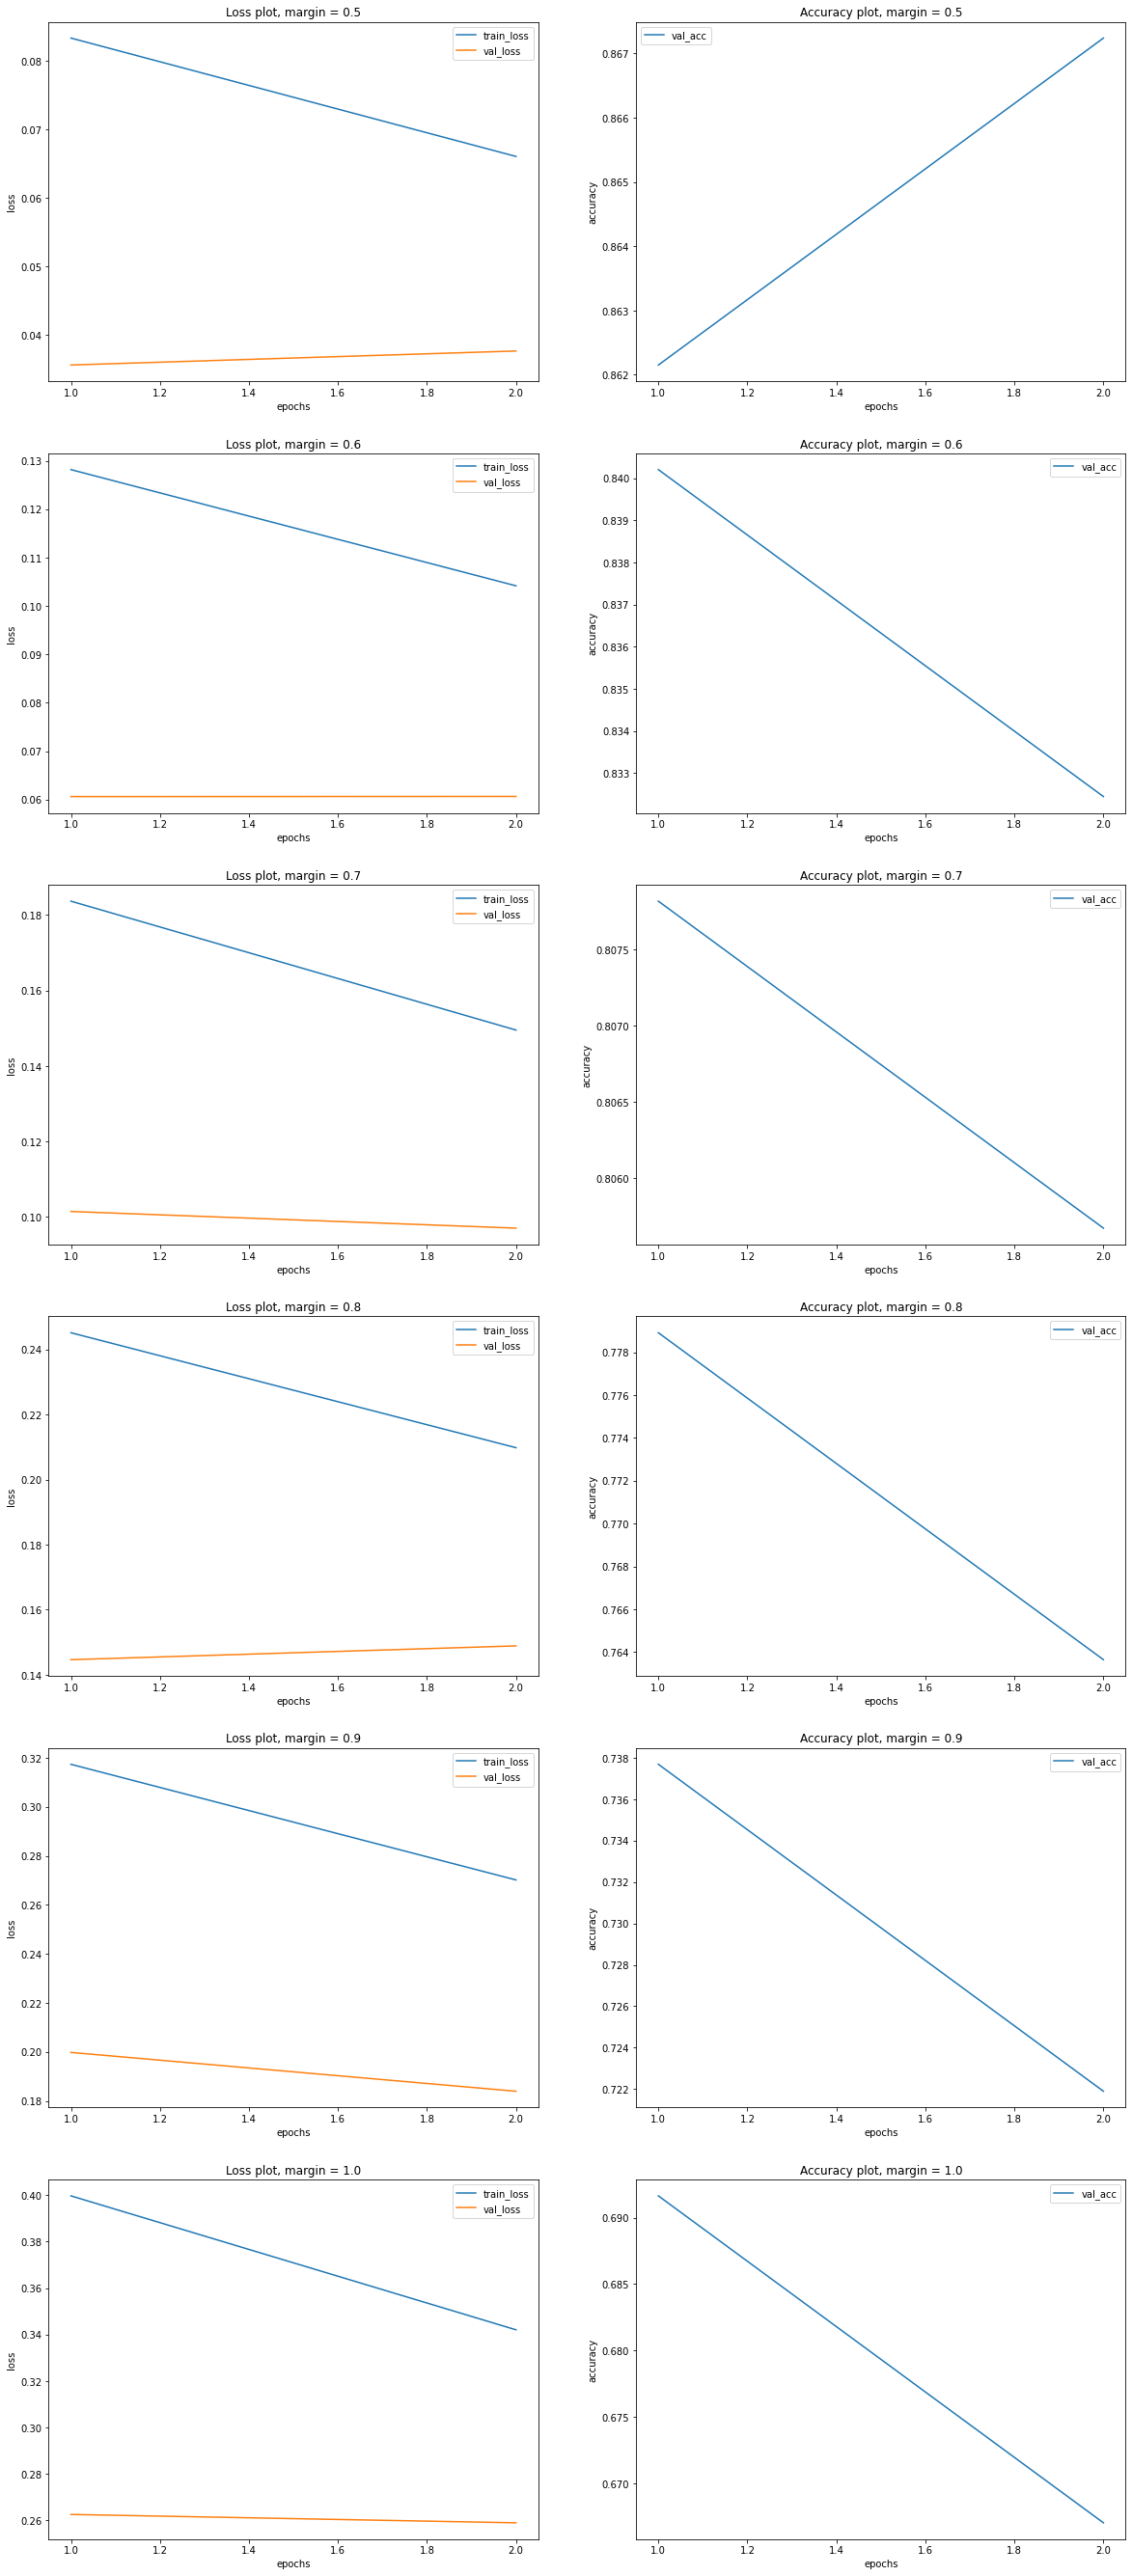

In [34]:
fig, axs = plt.subplots(6, 2, figsize=(20,48))
for i, MARGIN in enumerate([0.5, 0.6, 0.7, 0.8, 0.9,  1.0]):
    train_loss_TL = models_info[MARGIN][1]
    val_loss_TL = models_info[MARGIN][2]
    acc_TL = models_info[MARGIN][3]
    axs[i,0].set_title(f'Loss plot, margin = {MARGIN}')
    axs[i,0].plot(list(range(1, EPOCHS+1)), train_loss_TL, label='train_loss')
    axs[i,0].plot(list(range(1, EPOCHS+1)), val_loss_TL, label='val_loss')
    axs[i,0].legend()
    axs[i,0].set_xlabel('epochs')
    axs[i,0].set_ylabel('loss')

    axs[i,1].set_title(f'Accuracy plot, margin = {MARGIN}')
    axs[i,1].plot(list(range(1, EPOCHS+1)), acc_TL, label='val_acc')
    axs[i,1].legend()
    axs[i,1].set_xlabel('epochs')
    axs[i,1].set_ylabel('accuracy')

plt.show()

### ArcFace Loss (Additive Angular Margin Loss)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss.

To get the full mark for this task you need to train a model using TripletLoss correctly at least for one value of margin and achieve >=75% acc on test set.

In [12]:
class  ArcDataset(Dataset):
    def __init__(self, dataset_type, transform):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:int(y) for x, y in labels}
        self.labels = [labels[x.split('/')[-1]] for x in self.images]

        self.transform = transform

        self.df = pd.DataFrame(data={'original': self.images, 'label': self.labels})

        arcface_df = pd.DataFrame(columns=['label', 'positives'])

        for label in trange(1000):
            positives = list(self.df[self.df.label == label].original.values)
            arcface_df = arcface_df.append({'label': label, 'positives': positives}, ignore_index=True)
        self.arcface_df = arcface_df

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        label = self.labels[idx]

        image = Image.open(img_name)

        sample = {'image': self.transform(image), 'label': label}

        return (sample['image'], sample['label'])

In [13]:
train_ArcFace = ArcDataset('train', train_transform)
val_ArcFace = ArcDataset('val', transform)
test_ArcFace = ArcDataset('test', transform)

100%|██████████| 1000/1000 [00:03<00:00, 310.40it/s]


In [14]:
batch_size = 64
train_ArcFace_loader = torch.utils.data.DataLoader(train_ArcFace, batch_size=batch_size, shuffle=True)
val_ArcFace_loader = torch.utils.data.DataLoader(val_ArcFace, batch_size=batch_size, shuffle=False)
test_ArcFace_loader = torch.utils.data.DataLoader(test_ArcFace, batch_size=batch_size, shuffle=False)

In [15]:
class ArcFace_loss(nn.Module):
    def __init__(self, in_feat, out_feat, s=None, m=None, eps=1e-7):
        super(ArcFace_loss, self).__init__()

        self.s = 64.0 if not s else s
        self.m = 0.5 if not m else m

        self.fc = nn.Linear(in_feat, out_feat, bias=False)
        self.eps = eps

    def forward(self, logits, labels):
        '''
        logits: tensor(...) => [32, 512]
        labels: tensor([338, 317, ...]) => [32]
        '''
        for W in self.fc.parameters():
            W = F.normalize(W) # normalized weights

        x = F.normalize(logits) # normalized embeddings (feature) => [32, 512]
        wf = self.fc(x) # outputs of ArcFace Linear Layer => [32, 500]

        '''
        wf.transpose(0,1) -- wf.T => [500, 32] {1}
        {1}[labels] -- get rows by number 'label' from {1} => [32, 32] {2}
        torch.diagonal({2}) -- get diagonal values from {2} => [32] {3}
        torch.acos({3}) -- angle between the feature x_i and the ground truth weight W_y_i => [32]
        '''

        numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)

        '''
        [torch.cat((wf[i, :y], wf[i, y+1:])) for i, y in enumerate(labels)] # np.array(32,)
        numerator => [32]
        excl => [32, 499]
        denominator => [32]
        '''

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)

        L = numerator - torch.log(denominator)

        return -torch.mean(L)

In [31]:
def train_ArcFace_loss(model, train_loader, val_loader, opt, epochs=10):
    train_losses, val_losses, val_full_acc, train_full_acc = [], [], [], []
    best_acc = 0.0
    
    loss_fn = ArcFace_loss(512, 1000, s=15, m=0.01).to(DEVICE)
    best_model_weights = copy.deepcopy(model.state_dict())
    loss_optimizer = torch.optim.AdamW(loss_fn.parameters(), lr=3e-4)

    for epoch in range(epochs):
        print('Epoch %d/%d:' % (epoch+1, epochs))

        #train loop
        model.train()
        current_train_loss = 0
        current_train_correct = 0

        for inputs, labels in train_loader:
            X_batch = inputs.to(DEVICE)
            Y_batch = labels.to(DEVICE)

            # if opt:
            opt.zero_grad()
            loss_optimizer.zero_grad()

            #forward pass
            Y_pred = model(X_batch).to(DEVICE)
            loss = loss_fn(Y_pred, Y_batch) 

            #backward pass
            loss.backward()
            # if opt:
            opt.step()
            loss_optimizer.step()

            current_train_loss += loss.item() * X_batch.size(0)

        train_loss = current_train_loss / len(train_data)
        train_losses.append(train_loss)

        print(f'Train loss: {train_loss:.4f}')

        model.eval()
        with torch.no_grad():
            for label in trange(1000):
                positives = list(train_ArcFace.df[train_ArcFace.df.label == label].original.values)
                label_tensors = torch.stack([train_ArcFace.transform(Image.open(i)) for i in positives])
                model = model.cpu()
                labels_embedding = model(label_tensors).detach().numpy()
                label_mean_embedding = np.expand_dims(np.mean(labels_embedding, 0), 0)
                if label == 0:
                    list_embeddings = label_mean_embedding
                    continue
                list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)
        model = model.to(DEVICE)

        #validation loop
        model.eval()
        current_val_loss = 0
        current_val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                Y_pred = model(inputs.to(DEVICE))
                Y_val = labels.to(DEVICE)

                output = loss_fn(Y_pred, Y_val)

                cos = cosine_similarity(Y_pred.cpu(), list_embeddings)
                result = torch.argmax(torch.Tensor(cos), 1).to(DEVICE)
                current_val_loss += output.item()
                current_val_correct += torch.sum(result == Y_val).item()

        val_acc = current_val_correct / len(val_data)
        val_loss = current_val_loss / len(val_data)

        print(f'val loss = {val_loss}')
        print(f'val acc = {val_acc*100:.2f}%')
        val_losses.append(val_loss)
        val_full_acc.append(val_acc)

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            print('Save new model!')

    return (best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc)

In [32]:
Arc_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)

for param in Arc_model.parameters():
    param.requires_grad = False

Arc_model.last_linear = nn.Linear(in_features=1792, out_features=512, bias=False)
Arc_model.last_bn = nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)

Arc_model.to(DEVICE)

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [33]:
def get_list_embeddings_arc(model):
    model.eval()
    with torch.no_grad():
        for label in trange(1000):
            positives = list(train_ArcFace.df[train_ArcFace.df.label == label].original.values)
            label_tensors = torch.stack([train_ArcFace.transform(Image.open(i)) for i in positives])
            model = model.cpu()
            labels_embedding = model(label_tensors).detach().numpy()
            label_mean_embedding = np.expand_dims(np.mean(labels_embedding, 0), 0)
            if label == 0:
                list_embeddings = label_mean_embedding
                continue
            list_embeddings = np.concatenate((list_embeddings, label_mean_embedding), 0)
    return list_embeddings

In [34]:
def testing_Arc(model, test_loader, list_embeddings):
    model.eval()
    with torch.no_grad():
        current_correct = 0
        for anchor, label in test_loader:
            anchor_emb = model(anchor.to(DEVICE)).cpu()
            cos = cosine_similarity(anchor_emb.detach().numpy(), list_embeddings)
            result = torch.argmax(torch.Tensor(cos), 1)
            current_correct += torch.sum(result == label).item()

    test_acc = current_correct / len(test_ArcFace)

    first_text = f'You guessed {current_correct} of {len(test_ArcFace)} labels'
    second_text = f'Test accuracy: { test_acc*100:.3f}%'
    return current_correct, test_acc 

In [36]:
models_info = {}
EPOCHS = 5

#training
opt = optim.AdamW(filter(lambda p: p.requires_grad, Arc_model.parameters()), lr=3e-4)
best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc = train_ArcFace_loss(Arc_model, train_ArcFace_loader, val_ArcFace_loader, opt, epochs=EPOCHS)
models_info = [best_model_weights, train_losses, val_losses, val_full_acc, train_full_acc]

#save model
best_Arc_model = inception_resnet_v1.InceptionResnetV1(pretrained='vggface2', classify=False)
best_Arc_model.load_state_dict(best_model_weights)

#test model
print('Start testing')
list_embeddings = get_list_embeddings_arc(best_Arc_model.to(DEVICE))
current_correct, test_acc = testing_Arc(best_Arc_model.to(DEVICE), test_ArcFace_loader, list_embeddings)
models_info.extend([current_correct, test_acc])
print(f'Guessed {current_correct} of {len(test_ArcFace)} labels')
print(f'Test accuracy: {test_acc*100:.3f}%')
print()

Epoch 1/5:
Train loss: 5.5789


100%|██████████| 1000/1000 [14:10<00:00,  1.18it/s]


val loss = 0.06151635080129227
val acc = 92.67%
Save new model!
Epoch 2/5:
Train loss: 3.2264


100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s]


val loss = 0.0345547652665757
val acc = 92.37%
Epoch 3/5:
Train loss: 1.9051


100%|██████████| 1000/1000 [14:08<00:00,  1.18it/s]


val loss = 0.021003019295999785
val acc = 92.77%
Save new model!
Epoch 4/5:
Train loss: 1.2374


100%|██████████| 1000/1000 [14:07<00:00,  1.18it/s]


val loss = 0.016522160450064396
val acc = 92.05%
Epoch 5/5:
Train loss: 0.9015


100%|██████████| 1000/1000 [14:04<00:00,  1.18it/s]


val loss = 0.011444657873481959
val acc = 93.15%
Save new model!
Start testing


100%|██████████| 1000/1000 [13:23<00:00,  1.24it/s]


Guessed 2919 of 3174 labels
Test accuracy: 91.966%



# **Conclusion**:
As we could notice the ArcFace Loss accuracy is **91.966%** which is substantially higher than triplet loss accuracy which is **85.413%**. Furthermore ArcFace Loss require less changes to the architecture. Anyway Triplet Loss is a good choice as well, but it requires more difficult process of training.